### Import libraries

In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display
import plotly.express as px

In [22]:
df = pd.read_csv('/Users/hothanhphong/Downloads/lgg-mri-segmentation/kaggle_3m/data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [23]:
df['death01'].value_counts()

0.0    82
1.0    27
Name: death01, dtype: int64

In [24]:
df.head(5)

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [25]:
age = df["age_at_initial_pathologic"].value_counts()
fig = px.bar(age, title="Age of patients")
fig.update_layout(
    xaxis_title = "Age",
    yaxis_title = "Frequency",
    title_x = 0.5, 
    showlegend = False
)
fig.show()

In [26]:
data_map = []
for sub_dir_path in glob.glob("/Users/hothanhphong/Downloads/lgg-mri-segmentation/kaggle_3m/"+"*"):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/Users/hothanhphong/Downloads/lgg-mri-segmentation/kaggle_3m/data.csv'
[Errno 20] Not a directory: '/Users/hothanhphong/Downloads/lgg-mri-segmentation/kaggle_3m/README.md'


In [27]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

,patient_id,path
0,TCGA_CS_6667_20011105,/Users/hothanhphong/Downloads/lgg-mri-segmenta...
1,TCGA_CS_6667_20011105,/Users/hothanhphong/Downloads/lgg-mri-segmenta...
2,TCGA_CS_6667_20011105,/Users/hothanhphong/Downloads/lgg-mri-segmenta...
3,TCGA_CS_6667_20011105,/Users/hothanhphong/Downloads/lgg-mri-segmenta...
4,TCGA_CS_6667_20011105,/Users/hothanhphong/Downloads/lgg-mri-segmenta...


In [28]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

BASE_LEN = 105 
END_IMG_LEN = 4
END_MASK_LEN = 9

imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /Users/hothanhphong/Downloads/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_10.tif 
Path to the Mask: /Users/hothanhphong/Downloads/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_10_mask.tif


### Creating final datset

In [29]:
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

,patient_id,image_path,mask_path,mask
0,TCGA_CS_6667_20011105,/Users/hothanhphong/Downloads/lgg-mri-segmenta...,/Users/hothanhphong/Downloads/lgg-mri-segmenta...,0
1,TCGA_CS_6667_20011105,/Users/hothanhphong/Downloads/lgg-mri-segmenta...,/Users/hothanhphong/Downloads/lgg-mri-segmenta...,0
2,TCGA_CS_6667_20011105,/Users/hothanhphong/Downloads/lgg-mri-segmenta...,/Users/hothanhphong/Downloads/lgg-mri-segmenta...,0
3,TCGA_CS_6667_20011105,/Users/hothanhphong/Downloads/lgg-mri-segmenta...,/Users/hothanhphong/Downloads/lgg-mri-segmenta...,0
4,TCGA_CS_6667_20011105,/Users/hothanhphong/Downloads/lgg-mri-segmenta...,/Users/hothanhphong/Downloads/lgg-mri-segmenta...,0
...,...,...,...,...
3924,TCGA_FG_A60K_20040224,/Users/hothanhphong/Downloads/lgg-mri-segmenta...,/Users/hothanhphong/Downloads/lgg-mri-segmenta...,0
3925,TCGA_FG_A60K_20040224,/Users/hothanhphong/Downloads/lgg-mri-segmenta...,/Users/hothanhphong/Downloads/lgg-mri-segmenta...,0
3926,TCGA_FG_A60K_20040224,/Users/hothanhphong/Downloads/lgg-mri-segmenta...,/Users/hothanhphong/Downloads/lgg-mri-segmenta...,0
3927,TCGA_FG_A60K_20040224,/Users/hothanhphong/Downloads/lgg-mri-segmenta...,/Users/hothanhphong/Downloads/lgg-mri-segmenta...,0


### Data Visualization

In [20]:
brain_df['mask'].value_counts().values

array([2556, 1373])

Text(0.5, 1.005, 'Distribution of data grouped by patient and diagnosis')

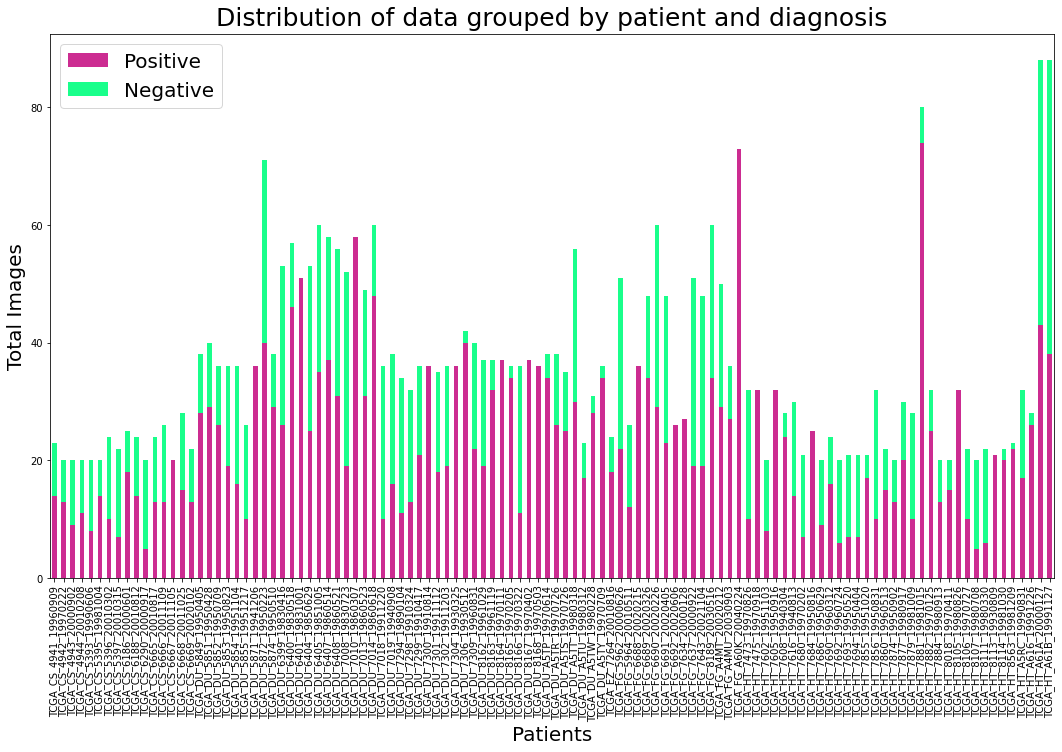

In [30]:
patients_by_diagnosis = brain_df.groupby(['patient_id', 'mask'])['mask'].size().unstack().fillna(0)
patients_by_diagnosis.columns = ["Positive", "Negative"]

# Plot
ax = patients_by_diagnosis.plot(kind='bar',stacked=True,
                                figsize=(18, 10),
                                color=["mediumvioletred", "springgreen"], 
                                alpha=0.9)
ax.legend(fontsize=20);
ax.set_xlabel('Patients',fontsize = 20)
ax.set_ylabel('Total Images', fontsize = 20)
ax.set_title("Distribution of data grouped by patient and diagnosis",fontsize = 25, y=1.005)


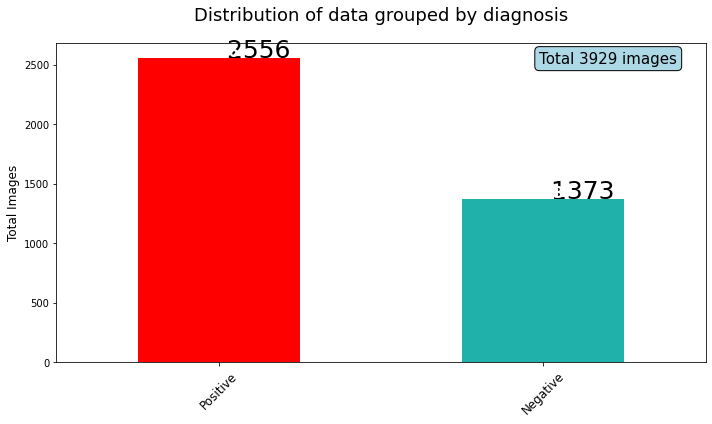

In [31]:
# Plot
ax = brain_df['mask'].value_counts().plot(kind='bar',
                                      stacked=True,
                                      figsize=(10, 6),
                                     color=["red", "lightseagreen"])

for index,data in enumerate(brain_df['mask'].value_counts()):
    plt.text(x= index , y = data , s =f" {data} " , fontdict=dict(fontsize=25))


ax.set_xticklabels(["Positive", "Negative"], rotation=45, fontsize=12);
ax.set_ylabel('Total Images', fontsize = 12)
ax.set_title("Distribution of data grouped by diagnosis",fontsize = 18, y=1.05)

# Annotate
for i, rows in enumerate(brain_df['mask'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows-12), 
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")
    
ax.text(1.2, 2550, f"Total {len(brain_df)} images", size=15,
        color="black",
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   fc=("lightblue"),
                   ec=("black"),
                   )
         );
plt.tight_layout()
plt.show()

In [32]:
image_size=set()
train_folder_path='/Users/hothanhphong/Downloads/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909'
for i in os.listdir(train_folder_path):
  image_size.add(cv2.imread(train_folder_path+'/'+i).shape)
unique_image=list(image_size)
for x in unique_image:
  print (x)

(256, 256, 3)


In [33]:
len(brain_df)

3929

Text(0.5, 1.0, 'Brain Image has Tumor')

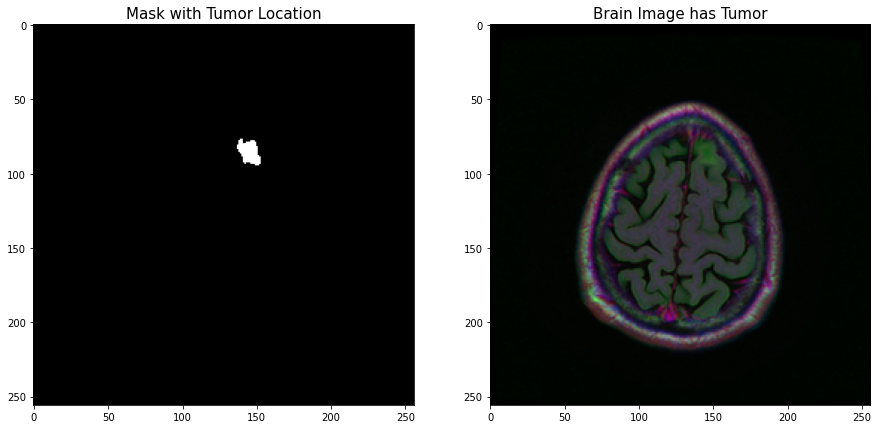

In [40]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(brain_df.mask_path[3001]));
plt.title('Mask with Tumor Location', fontsize = 15)

plt.subplot(1,2,2)
plt.imshow(cv2.imread(brain_df.image_path[3001]));
plt.title('Brain Image has Tumor', fontsize = 15)

Text(0.5, 1.0, 'Brain Image does not have Tumor')

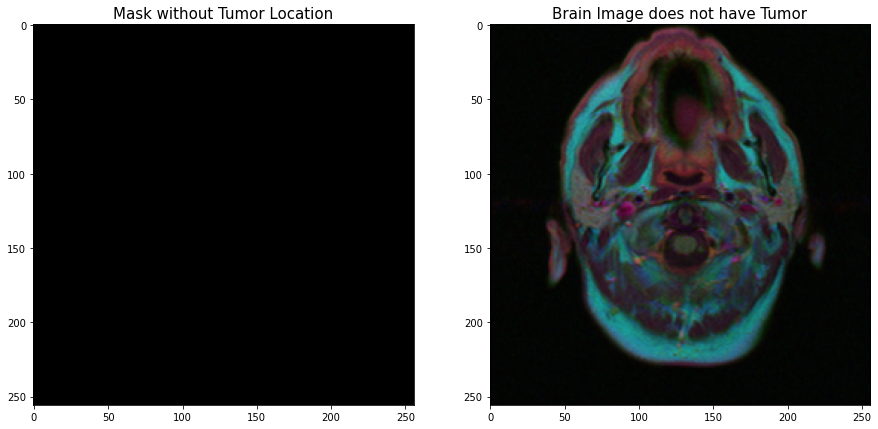

In [37]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(brain_df.mask_path[31]));
plt.title('Mask without Tumor Location', fontsize = 15)

plt.subplot(1,2,2)
plt.imshow(cv2.imread(brain_df.image_path[31]));
plt.title('Brain Image does not have Tumor', fontsize = 15)

In [42]:
cv2.imread(brain_df.mask_path[200]).max(), cv2.imread(brain_df.mask_path[200]).min()

(0, 0)

In [43]:
cv2.imread(brain_df.image_path[300]).max(), cv2.imread(brain_df.image_path[300]).min()

(247, 0)

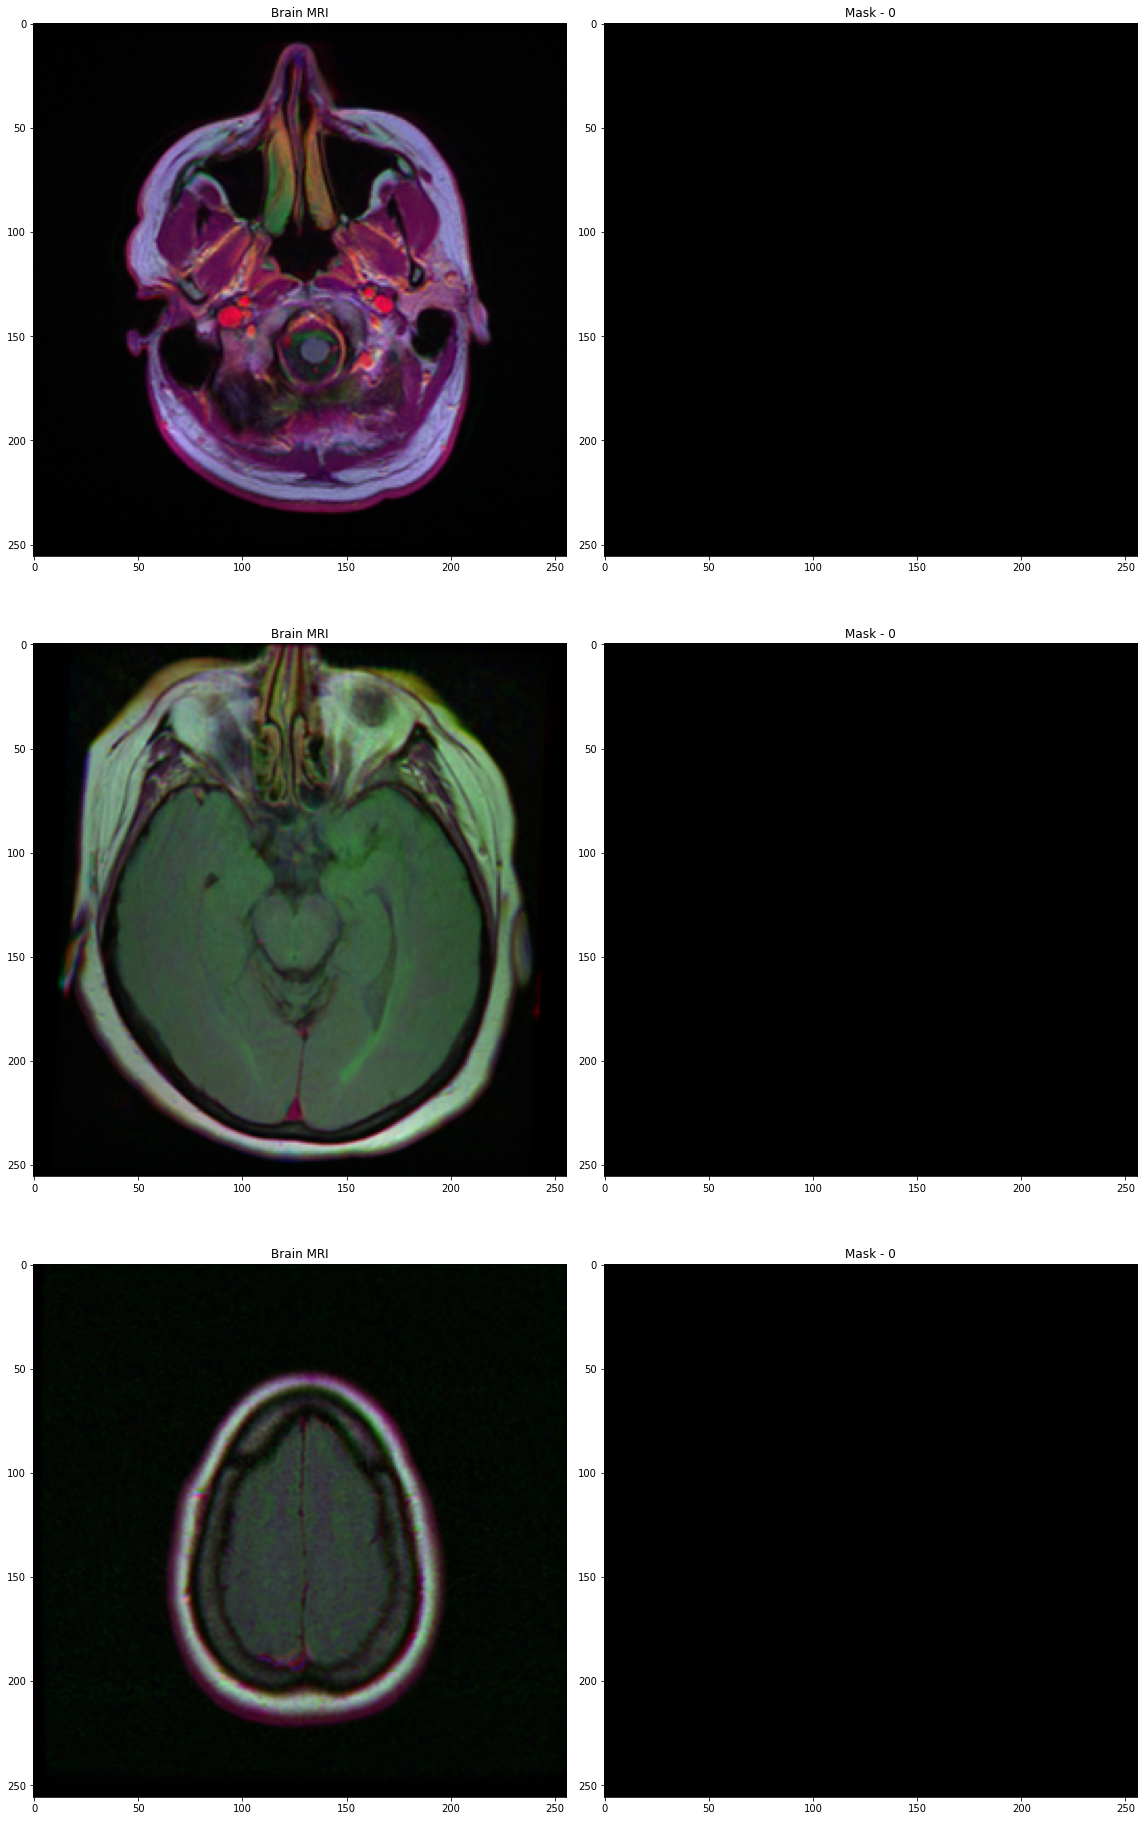

In [44]:
fig, axs = plt.subplots(3,2, figsize=(16,26))
count = 0
for x in range(3):
  i = random.randint(0, len(brain_df)) 
  axs[count][0].title.set_text("Brain MRI") 
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) 
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i]))
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i]))
  count += 1

fig.tight_layout()

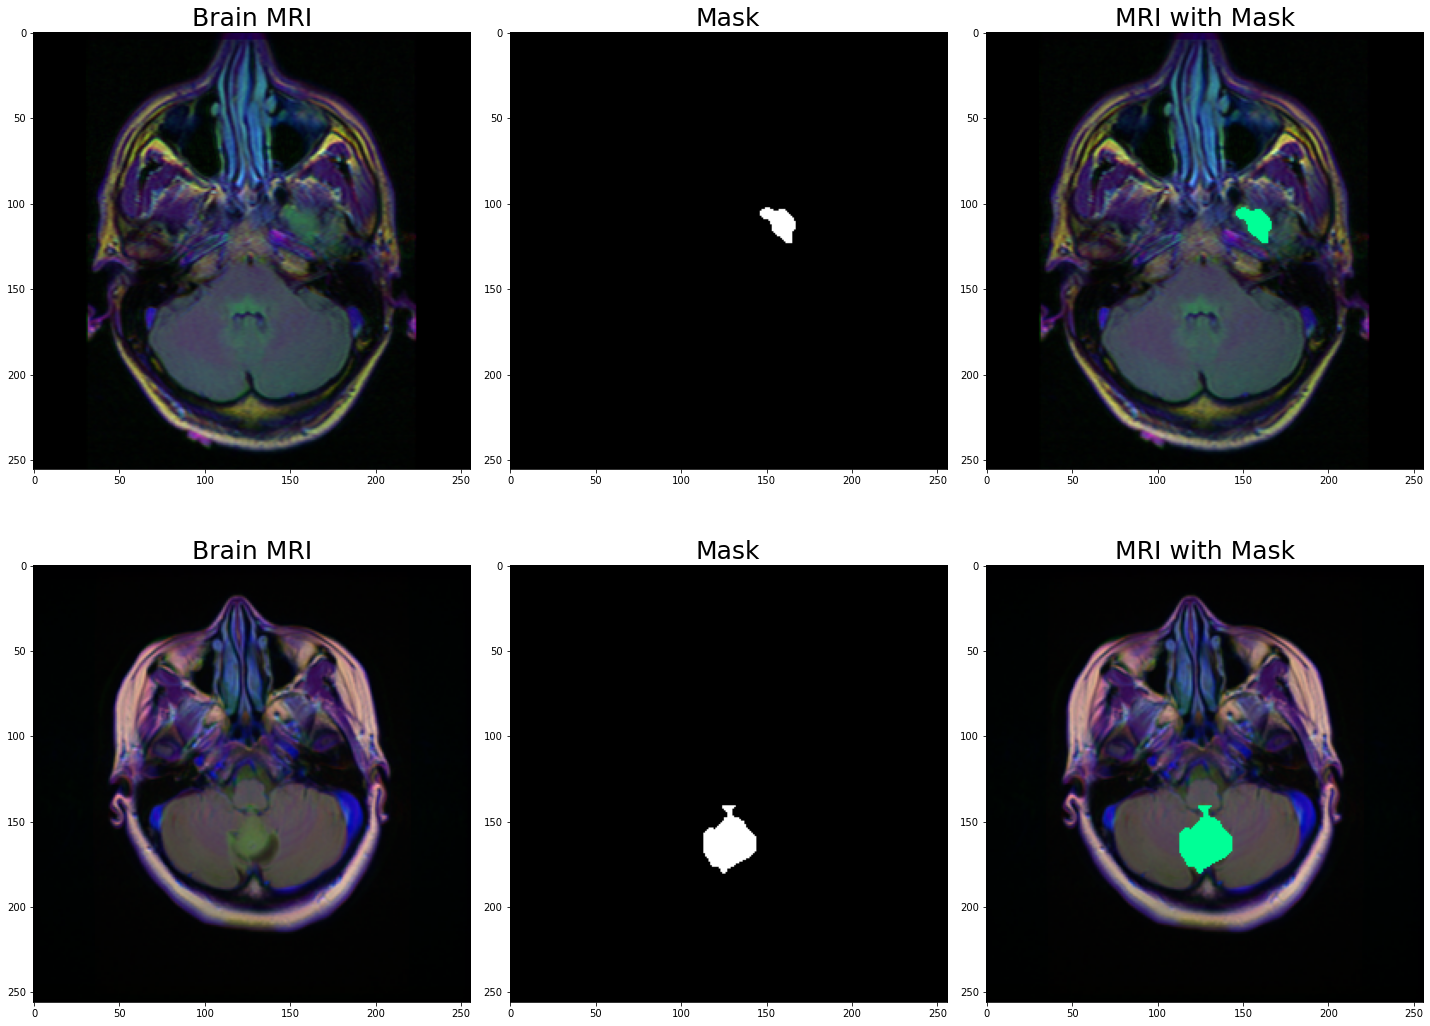

In [45]:
count = 0
i = 0
fig,axs = plt.subplots(2,3, figsize=(20,15))
for mask in brain_df['mask']:
    if (mask==1):
        img = io.imread(brain_df.image_path[i])
        axs[count][0].set_title("Brain MRI", fontsize = 25)
        axs[count][0].imshow(img)
        
        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].set_title("Mask", fontsize = 25)
        axs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (0,255,150)  # change pixel color at the position of mask
        axs[count][2].set_title("MRI with Mask", fontsize = 25)
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==2):
        break
        
fig.tight_layout()

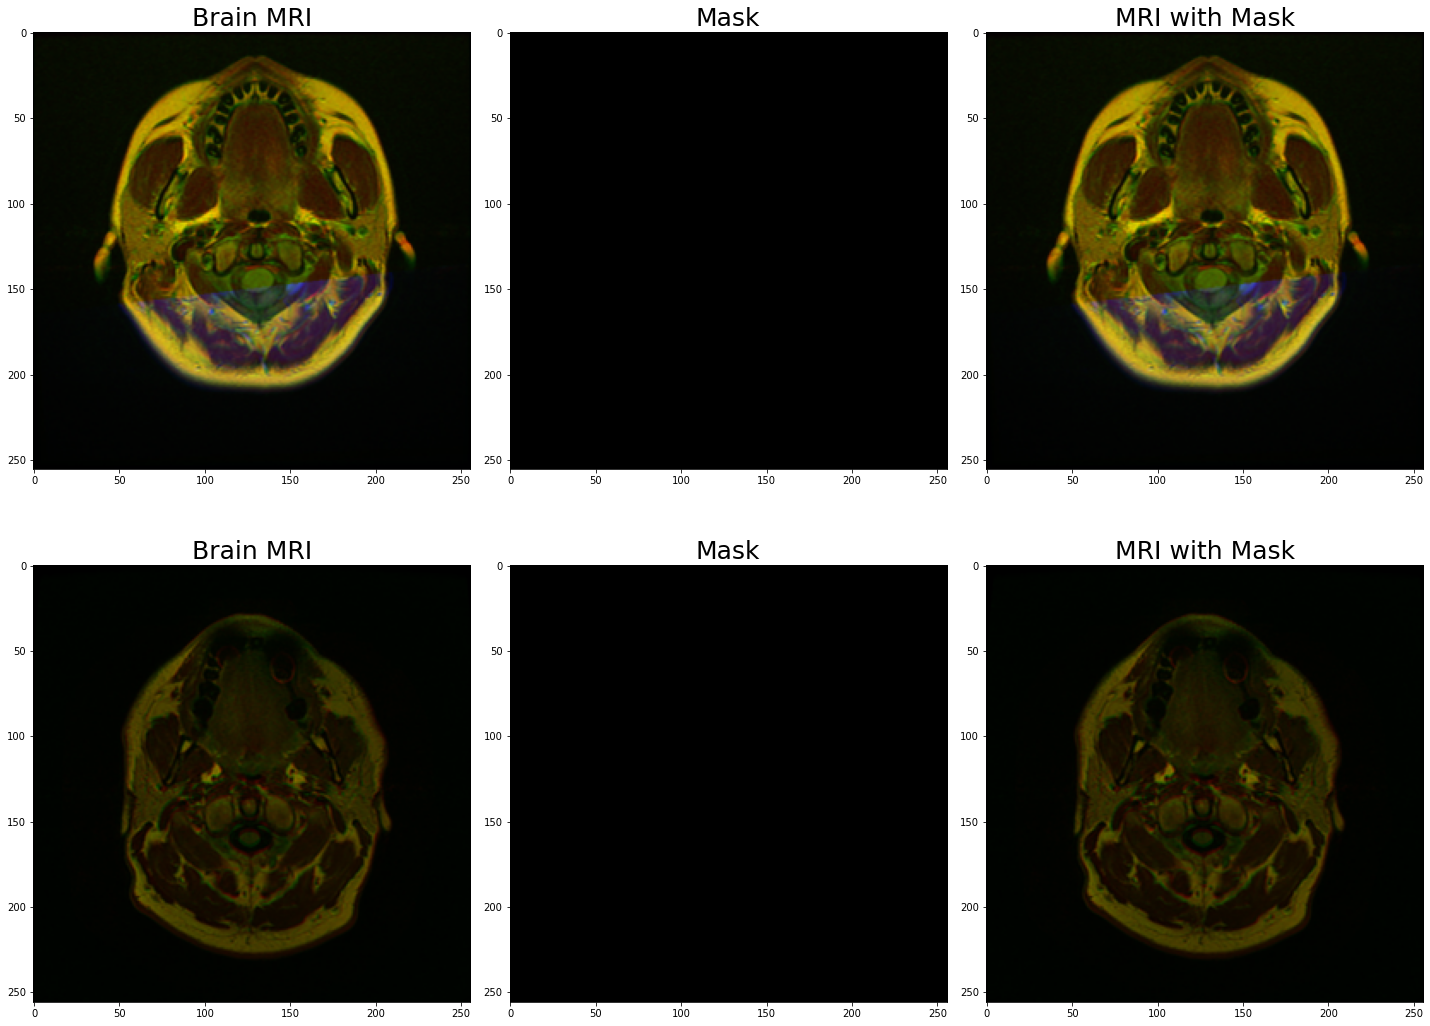

In [46]:
count = 0
i = 0
fig,axs = plt.subplots(2,3, figsize=(20,15))
for mask in brain_df['mask']:
    if (mask==0):
        img = io.imread(brain_df.image_path[i])
        axs[count][0].set_title("Brain MRI", fontsize = 25)
        axs[count][0].imshow(img)
        
        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].set_title("Mask", fontsize = 25)
        axs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (0,255,150)  # change pixel color at the position of mask
        axs[count][2].set_title("MRI with Mask", fontsize = 25)
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==2):
        break
        
fig.tight_layout()

### Creating Train, validation and test set

In [47]:
brain_df_train = brain_df.drop(columns=['patient_id'])
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [48]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size=0.15)

In [49]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255., validation_split=0.15)

train_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='training',
                                              class_mode='categorical',
                                              batch_size=32,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
valid_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='validation',
                                              class_mode='categorical',
                                              batch_size=32,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='image_path',
                                                  y_col='mask',
                                                  class_mode='categorical',
                                                  batch_size=32,
                                                  shuffle=False,
                                                  target_size=(256,256)
                                                 )

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [50]:
datagen

### Classification modeling

In [51]:
from tensorflow.keras.applications.resnet50 import ResNet50
clf_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
clf_model.summary()

2022-04-19 01:03:30.456830: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 64, 64, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 32, 32, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 8, 8, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 8, 8, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 8, 8, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [39]:
for layer in clf_model.layers:
    layers.trainable = False

In [26]:
head = clf_model.output
head = AveragePooling2D(pool_size=(4,4))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(2, activation='softmax')(head)

model = Model(clf_model.input, head)
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics= ["accuracy"]
             )
model.summary()

In [27]:
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-resnet-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]

In [28]:
h = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 100, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              callbacks=[checkpointer, earlystopping, reduce_lr])

In [29]:
model_json = model.to_json()
with open("clf-resnet-model.json", "w") as json_file:
    json_file.write(model_json)

### Classification model evaluation

In [30]:
h.history.keys()

In [31]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model Loss");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("Classification Model Accuracy");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [32]:
_, acc = model.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

In [33]:
prediction = model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);

### Segmentation modelling

In [34]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

In [35]:
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [36]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 32, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    #generate index of batch_size length
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
    list_ids = [self.ids[i] for i in indexes]

    #get the MaskId corresponding to the indexes created above based on batch size
    list_mask = [self.mask[i] for i in indexes]


    #generate data for the X(features) and y(label)
    X, y = self.__data_generation(list_ids, list_mask)

    #returning the data
    return X, y

  def on_epoch_end(self):
    'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'
    
    #getting the array of indices based on the input dataframe
    self.indexes = np.arange(len(self.ids))

    #if shuffle is true, shuffle the indices
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth) 
    #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iterate through the dataframe rows, whose size is equal to the batch_size
    for i in range(len(list_ids)):
      #path of the image
      img_path = str(list_ids[i])
      
      #mask path
      mask_path = str(list_mask[i])
      
      #reading the original image and the corresponding mask image
      img = io.imread(img_path)
      mask = io.imread(mask_path)

      #resizing and coverting them to array of type float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
      
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #standardising 
      img -= img.mean()
      img /= img.std()
      
      mask -= mask.mean()
      mask /= mask.std()
      
      #Adding image to the empty array
      X[i,] = img
      
      #expanding the dimnesion of the image from (256,256) to (256,256,1)
      y[i,] = np.expand_dims(mask, axis = 2)
    
    #normalizing y
    y = (y > 0).astype(int)

    return X, y

train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)

In [37]:
# lets create model now
def resblock(X, f):
    '''
    function for creating res block
    '''
    X_copy = X  #copy of input
    
    # main path
    X = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(f, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    
    # shortcut path
    X_copy = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)
    
    # Adding the output from main path and short path together
    X = Add()([X, X_copy])
    X = Activation('relu')(X)
    
    return X

def upsample_concat(x, skip):
    '''
    funtion for upsampling image
    '''
    X = UpSampling2D((2,2))(x)
    merge = Concatenate()([X, skip])
    
    return merge

In [38]:
input_shape = (256,256,3)
X_input = Input(input_shape) #iniating tensor of input shape

# Stage 1
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
conv_1 = BatchNormalization()(conv_1)
pool_1 = MaxPool2D((2,2))(conv_1)

# stage 2
conv_2 = resblock(pool_1, 32)
pool_2 = MaxPool2D((2,2))(conv_2)

# Stage 3
conv_3 = resblock(pool_2, 64)
pool_3 = MaxPool2D((2,2))(conv_3)

# Stage 4
conv_4 = resblock(pool_3, 128)
pool_4 = MaxPool2D((2,2))(conv_4)

# Stage 5 (bottle neck)
conv_5 = resblock(pool_4, 256)

# Upsample Stage 1
up_1 = upsample_concat(conv_5, conv_4)
up_1 = resblock(up_1, 128)

# Upsample Stage 2
up_2 = upsample_concat(up_1, conv_3)
up_2 = resblock(up_2, 64)

# Upsample Stage 3
up_3 = upsample_concat(up_2, conv_2)
up_3 = resblock(up_3, 32)

# Upsample Stage 4
up_4 = upsample_concat(up_3, conv_1)
up_4 = resblock(up_4, 16)

# final output
out = Conv2D(1, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)

seg_model = Model(X_input, out)
seg_model.summary()

In [39]:
# Define a custom loss function for ResUNet model
'''
actual link for refrence (https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py)
'''
from keras.losses import binary_crossentropy

epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [40]:
# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(learning_rate = 0.005, epsilon = 0.1)
seg_model.compile(optimizer = adam, 
                  loss = focal_tversky, 
                  metrics = [tversky]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=20
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-segModel-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [41]:
h = seg_model.fit(train_data, 
                  epochs = 100, 
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr]
                 )

In [42]:
seg_model_json = seg_model.to_json()
with open("ResUNet-seg-model.json", "w") as json_file:
    json_file.write(seg_model_json)

### Segmentation model evaluation

In [43]:
h.history.keys()

In [44]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("SEG Model focal tversky Loss");
plt.ylabel("focal tversky loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['tversky']);
plt.plot(h.history['val_tversky']);
plt.title("SEG Model tversky score");
plt.ylabel("tversky Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [45]:
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)
test_data = DataGenerator(test_ids, test_mask)
_, tv = seg_model.evaluate(test_data)
print("Segmentation tversky is {:.2f}%".format(tv*100))

### Segmentation model performance 
### (combine classification model and segmetation model pipeline)

In [46]:
def prediction(test, model, model_seg):
    '''
    Predcition function which takes dataframe containing ImageID as Input and perform 2 type of prediction on the image
    Initially, image is passed through the classification network which predicts whether the image has defect or not, if the model
    is 99% sure that the image has no defect, then the image is labeled as no-defect, if the model is not sure, it passes the image to the
    segmentation network, it again checks if the image has defect or not, if it has defect, then the type and location of defect is found
    '''
    # empty list to store results
    mask, image_id, has_mask = [], [], []
    
    #itetrating through each image in test data
    for i in test.image_path:
        
        img = io.imread(i)
        #normalizing
        img = img *1./255.
        #reshaping
        img = cv2.resize(img, (256,256))
        # converting img into array
        img = np.array(img, dtype=np.float64)
        #reshaping the image from 256,256,3 to 1,256,256,3
        img = np.reshape(img, (1,256,256,3))
        
        #making prediction for tumor in image
        is_defect = model.predict(img)
        
        #if tumour is not present we append the details of the image to the list
        if np.argmax(is_defect)==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
            continue
        
        #Creating a empty array of shape 1,256,256,1
        X = np.empty((1,256,256,3))
        # read the image
        img = io.imread(i)
        #resizing the image and coverting them to array of type float64
        img = cv2.resize(img, (256,256))
        img = np.array(img, dtype=np.float64)
        
        # standardising the image
        img -= img.mean()
        img /= img.std()
        #converting the shape of image from 256,256,3 to 1,256,256,3
        X[0,] = img
        
        #make prediction of mask
        predict = model_seg.predict(X)
        
        # if sum of predicted mask is 0 then there is not tumour
        if predict.round().astype(int).sum()==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
        else:
        #if the sum of pixel values are more than 0, then there is tumour
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)
            
    return pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})

In [47]:
df_pred = prediction(test, model, seg_model)
df_pred

In [48]:
df_pred = test.merge(df_pred, on='image_path')
df_pred.head(10)

In [49]:
count = 0
fig, axs = plt.subplots(15,5, figsize=(30,70))

for i in range(len(df_pred)):
    if df_pred.has_mask[i]==1 and count<15:
        #read mri images
        img = io.imread(df_pred.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI')
        
        #read original mask
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text('Original Mask')
        
        #read predicted mask
        pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text('AI predicted mask')
        
        #overlay original mask with MRI
        img[mask==255] = (255,0,0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('Brain MRI with original mask (Ground Truth)')
        
        #overlay predicted mask and MRI
        img_ = io.imread(df_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred==1] = (0,255,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('MRI with AI PREDICTED MASK')
        
        count +=1
    if (count==15):
        break

fig.tight_layout()        